In [1]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import argparse
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import sys
sys.path.append('..')
from models.common_autoencoder_blocks import Encoder  
from models.cifar10_supconv import CIFAR10SupCon
from trainers.supcon_trainer import SupConTrainer
from trainers.classifier_trainer import ClassifierTrainer
from models.cifar10_classifier import CIFAR10Classifier
device = 'cuda' if torch.cuda.is_available() else 'cpu'



In [2]:
class TwoCropsTransform:
    def __init__(self, base_transform):
        self.base_transform = base_transform

    def __call__(self, x):
        im1 = self.base_transform(x)
        im2 = self.base_transform(x)
        return im1, im2


base_transform = transforms.Compose([
    transforms.RandomResizedCrop(32, scale=(0.8, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomAffine(degrees=10, translate=(0.1, 0.1), shear=5),
    transforms.RandomApply([transforms.GaussianBlur(kernel_size=3, sigma=(0.1, 1.0))], p=0.2),
    transforms.ToTensor(),
])

train_transform = TwoCropsTransform(base_transform)
val_base_transform = transforms.Compose([transforms.ToTensor()])
val_transform = TwoCropsTransform(val_base_transform)

data_path = os.path.join("..", "data")
train_dataset = datasets.CIFAR10(root=data_path, train=True, download=True, transform=train_transform)
val_dataset = datasets.CIFAR10(root=data_path, train=False, download=True, transform=val_transform)

train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True, num_workers=2, drop_last=True)
val_loader = DataLoader(val_dataset, batch_size=256, shuffle=False, num_workers=2, drop_last=True)


Files already downloaded and verified
Files already downloaded and verified


[Epoch 1] TrainLoss=5.9659, ValLoss=5.7884
[Epoch 2] TrainLoss=5.8246, ValLoss=5.6836
[Epoch 3] TrainLoss=5.7455, ValLoss=5.6325
[Epoch 4] TrainLoss=5.6773, ValLoss=5.5719
[Epoch 5] TrainLoss=5.6160, ValLoss=5.4904
[Epoch 6] TrainLoss=5.5632, ValLoss=5.4715
[Epoch 7] TrainLoss=5.5180, ValLoss=5.4246
[Epoch 8] TrainLoss=5.4746, ValLoss=5.3972
[Epoch 9] TrainLoss=5.4302, ValLoss=5.3537
[Epoch 10] TrainLoss=5.3939, ValLoss=5.3442
[Epoch 11] TrainLoss=5.3538, ValLoss=5.3299
[Epoch 12] TrainLoss=5.3147, ValLoss=5.2855
[Epoch 13] TrainLoss=5.2868, ValLoss=5.3446
[Epoch 14] TrainLoss=5.2599, ValLoss=5.2363
[Epoch 15] TrainLoss=5.2314, ValLoss=5.2415
[Epoch 16] TrainLoss=5.2051, ValLoss=5.2458
[Epoch 17] TrainLoss=5.1816, ValLoss=5.2369
[Epoch 18] TrainLoss=5.1514, ValLoss=5.1848
[Epoch 19] TrainLoss=5.1308, ValLoss=5.1879
[Epoch 20] TrainLoss=5.1113, ValLoss=5.2131
[Epoch 21] TrainLoss=5.0808, ValLoss=5.2362
[Epoch 22] TrainLoss=5.0628, ValLoss=5.1824
[Epoch 23] TrainLoss=5.0465, ValLoss=5.17

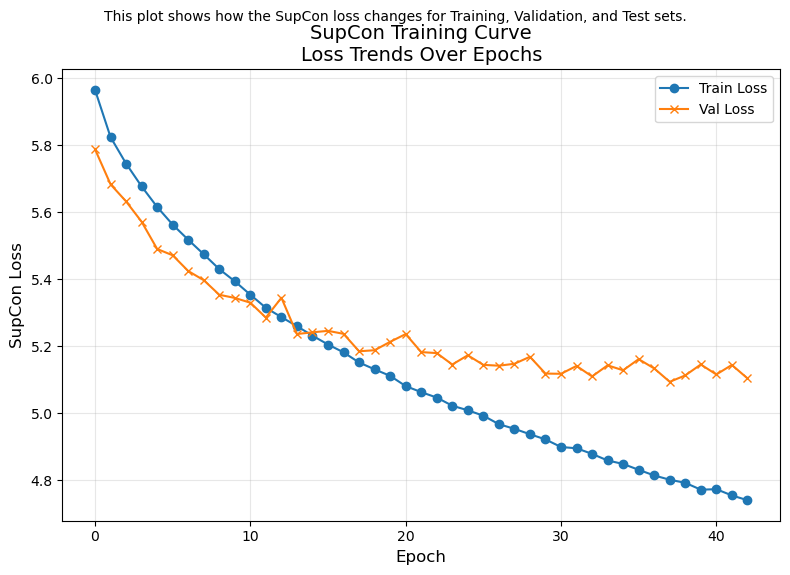

=== Final SupCon Metrics ===
Train Loss: 4.7399
Val   Loss: 5.1041


In [20]:
supcon = CIFAR10SupCon(
    input_shape=(3, 32, 32),
    channels=[64, 128,256,512],  # maybe deeper for CIFAR10
    kernel_sizes=[3, 3, 3,3],
    strides=[2, 2, 2,2],
    paddings=[1, 1, 1,1],
    latent_dim=128,
    dropout_rate=0.1,
    hidden_dims=[1024],
    batch_norm_conv=True
)
optimizer = torch.optim.Adam(supcon.parameters(), lr=1e-4, weight_decay=1e-4)

supcon_trainer = SupConTrainer(
    model=supcon,
    train_loader=train_loader,
    val_loader=val_loader,
    optimizer=optimizer,
    device=device,
    num_epochs=60,
    patience=5,
    temperature=0.2
)
supcon_trainer.train()
supcon_trainer.plot_metrics()

Files already downloaded and verified
Files already downloaded and verified
Epoch [1] - TrainAcc: 0.7543, ValAcc: 0.7905 | ValLoss: 0.8285
Epoch [2] - TrainAcc: 0.8510, ValAcc: 0.7916 | ValLoss: 0.7135
Epoch [3] - TrainAcc: 0.8506, ValAcc: 0.7903 | ValLoss: 0.6802
Epoch [4] - TrainAcc: 0.8547, ValAcc: 0.7902 | ValLoss: 0.6682
Epoch [5] - TrainAcc: 0.8550, ValAcc: 0.7905 | ValLoss: 0.6720
Epoch [6] - TrainAcc: 0.8571, ValAcc: 0.7890 | ValLoss: 0.6721
Epoch [7] - TrainAcc: 0.8580, ValAcc: 0.7891 | ValLoss: 0.6742
Epoch [8] - TrainAcc: 0.8563, ValAcc: 0.7877 | ValLoss: 0.6867
Epoch [9] - TrainAcc: 0.8596, ValAcc: 0.7881 | ValLoss: 0.6921
Epoch [10] - TrainAcc: 0.8587, ValAcc: 0.7894 | ValLoss: 0.6824
Epoch [11] - TrainAcc: 0.8583, ValAcc: 0.7909 | ValLoss: 0.6857
Epoch [12] - TrainAcc: 0.8593, ValAcc: 0.7915 | ValLoss: 0.6800
Epoch [13] - TrainAcc: 0.8595, ValAcc: 0.7901 | ValLoss: 0.6815
Epoch [14] - TrainAcc: 0.8592, ValAcc: 0.7895 | ValLoss: 0.6934
Early stopping triggered at epoch 14


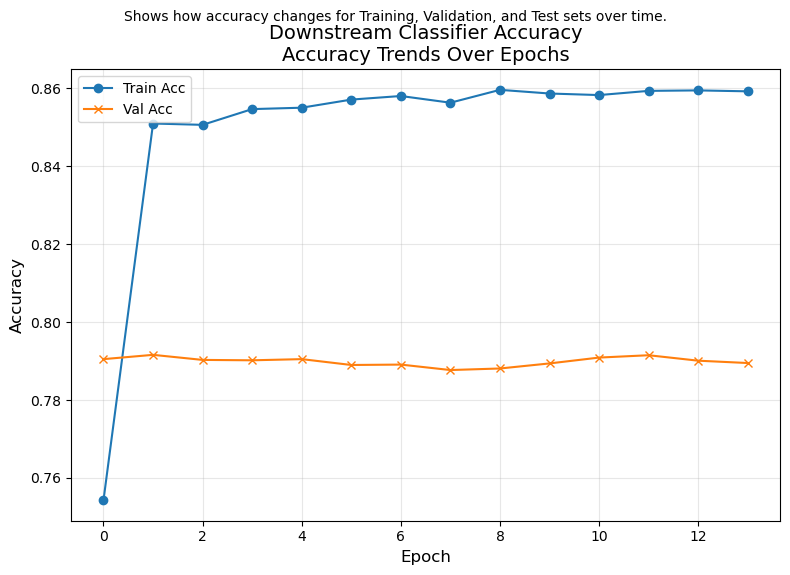

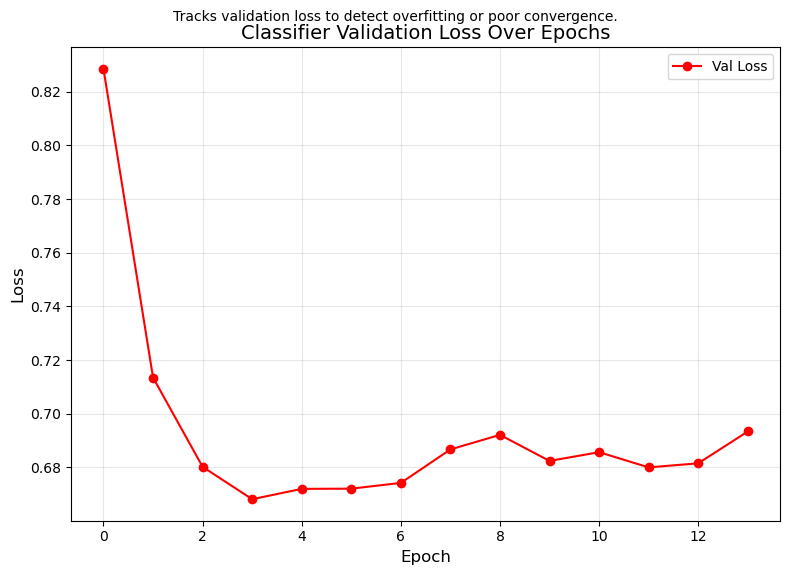

=== Final Classifier Metrics ===
Val Loss: 0.6934
Train Acc: 85.92%
Val   Acc: 78.95%


In [22]:
classifier_train_transform = transforms.Compose([
    transforms.RandomResizedCrop(32, scale=(0.8, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomAffine(degrees=10, translate=(0.1, 0.1), shear=5),
    transforms.ToTensor(),
])

classifier_val_transform = val_base_transform  


train_dataset_calssification = datasets.CIFAR10(root=data_path, train=True, download=True, transform=classification_train_transform)
val_dataset_calssification   = datasets.CIFAR10(root=data_path, train=False, download=True, transform=classification_val_transform)
train_calssification_loader = DataLoader(train_dataset_calssification, batch_size=128, shuffle=True)
val_calssification_loader = DataLoader(val_dataset_calssification, batch_size=128, shuffle=False)
classifier = CIFAR10Classifier(latent_dim=128, num_classes=10, dropout_fc = 0.2, batch_norm_fc=True) 
classifier_trainer = ClassifierTrainer(
    encoder=supcon,
    classifier=classifier,
    train_loader=train_calssification_loader,
    val_loader=val_calssification_loader,
    device=device,
    lr=5e-5,
    weight_decay=3e-4,
    num_epochs=60,
    patience=10,
)
classifier_trainer.train()
classifier_trainer.plot_metrics()